In [42]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im NASDAQ 100

Zunächst werden die Kursdaten geladen und bereinigt

In [43]:
SYMBOL = "^NDX"
stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren werden für spätere Auswertungen mit hinzugefügt

In [44]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [45]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

In [46]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        # long signal
        self.hold = self.I(
            lambda: self.data.hold,
            overlay=True,
            name="Hold",
            scatter=True,
            color="green",
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.buy[-1] == -1:
                    trade.close()

        # ORDER_SIZE = 0.5

        if self.data.buy[-1] == 1:
            self.buy()

In [47]:
from backtesting import Backtest

bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run()
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='7484', ...)

In [48]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-15 00:00:00
Duration                   4486 days 00:00:00
Exposure Time [%]                   47.702265
Equity Final [$]                208219.600941
Equity Peak [$]                 210031.077504
Return [%]                         108.219601
Buy & Hold Return [%]              675.673838
Return (Ann.) [%]                    6.163816
Volatility (Ann.) [%]               14.104288
Sharpe Ratio                         0.437017
Sortino Ratio                        0.665777
Calmar Ratio                         0.263429
Max. Drawdown [%]                  -23.398426
Avg. Drawdown [%]                   -3.540852
Max. Drawdown Duration     1332 days 00:00:00
Avg. Drawdown Duration       87 days 00:00:00
# Trades                                  148
Win Rate [%]                        60.810811
Best Trade [%]                       9.956863
Worst Trade [%]                    -13.864262
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [49]:
stats["Win Rate [%]"]

60.810810810810814

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [50]:
stats["Avg. Trade [%]"]

0.5105690721624034

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [51]:
stats["Profit Factor"]

1.5494249370105162

In [52]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [53]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.06].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0453
2,0.0730
3,-0.1756
4,0.1246
5,-0.0788
6,0.2149
7,0.2347
8,0.1262
9,0.0333


<Axes: title={'center': 'Gewinner Trades'}>

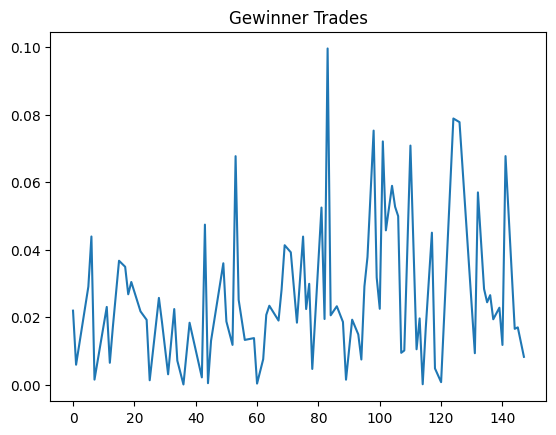

In [54]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

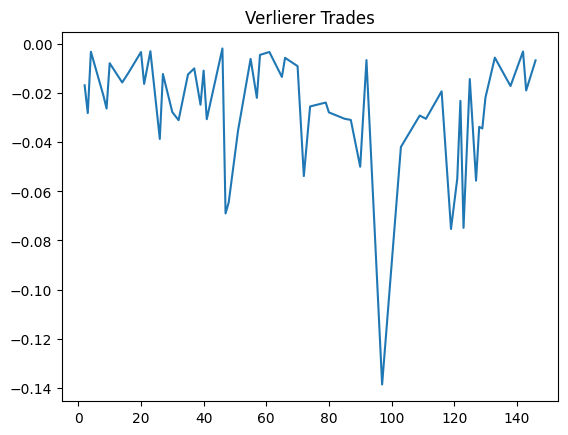

In [55]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [56]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.buy[-1] == -1:
                    trade.close()

        # ORDER_SIZE = 0.5

        if self.data.buy[-1] == 1 and self.data.month[-1] not in skip_month:
            self.buy()

In [57]:
bt = Backtest(
    df["2012-01-01":], end_of_month_and_skip_month, cash=100_000, commission=0.002
)
stats = bt.run()
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='8682', ...)

In [58]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-15 00:00:00
Duration                   4486 days 00:00:00
Exposure Time [%]                   27.831715
Equity Final [$]                262873.786955
Equity Peak [$]                 265152.423674
Return [%]                         162.873787
Buy & Hold Return [%]              675.673838
Return (Ann.) [%]                    8.201135
Volatility (Ann.) [%]               10.448912
Sharpe Ratio                         0.784879
Sortino Ratio                        1.305756
Calmar Ratio                         0.824831
Max. Drawdown [%]                   -9.942812
Avg. Drawdown [%]                   -2.463519
Max. Drawdown Duration      427 days 00:00:00
Avg. Drawdown Duration       61 days 00:00:00
# Trades                                   86
Win Rate [%]                         67.44186
Best Trade [%]                       7.884494
Worst Trade [%]                     -6.453355
Avg. Trade [%]                    

In [59]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [60]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
2,0.0730
4,0.1163
6,0.2149
7,0.2347
8,0.1262
11,0.2110
12,0.0630
